In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pylab import rcParams
from time import time

from sklearn import metrics
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn import kernel_approximation
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.kernel_approximation import (RBFSampler, Nystroem)
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix


rcParams['figure.figsize'] = 15, 8




In [2]:
data = pd.read_csv("No-show-Issue-Comma-300k-Dataset.csv")

data.head(10)

## Ingestion of the CSV dataset


,Age,Gender,AppointmentRegistration,ApointmentData,DayOfTheWeek,Status,Diabetes,Alcoolism,HiperTension,Handcap,Smokes,Scholarship,Tuberculosis,Sms_Reminder,AwaitingTime
0,19,M,2014-12-16T14:46:25Z,2015-01-14T00:00:00Z,Wednesday,Show-Up,0,0,0,0,0,0,0,0,-29
1,24,F,2015-08-18T07:01:26Z,2015-08-19T00:00:00Z,Wednesday,Show-Up,0,0,0,0,0,0,0,0,-1
2,4,F,2014-02-17T12:53:46Z,2014-02-18T00:00:00Z,Tuesday,Show-Up,0,0,0,0,0,0,0,0,-1
3,5,M,2014-07-23T17:02:11Z,2014-08-07T00:00:00Z,Thursday,Show-Up,0,0,0,0,0,0,0,1,-15
4,38,M,2015-10-21T15:20:09Z,2015-10-27T00:00:00Z,Tuesday,Show-Up,0,0,0,0,0,0,0,1,-6
5,5,F,2014-06-17T06:47:27Z,2014-07-22T00:00:00Z,Tuesday,No-Show,0,0,0,0,0,0,0,1,-35
6,46,F,2015-06-19T19:53:58Z,2015-07-07T00:00:00Z,Tuesday,Show-Up,0,0,0,0,0,0,0,1,-18
7,4,F,2015-08-07T08:19:19Z,2015-08-21T00:00:00Z,Friday,Show-Up,0,0,0,0,0,1,0,1,-14
8,20,F,2014-10-14T11:46:36Z,2014-10-28T00:00:00Z,Tuesday,Show-Up,0,0,0,0,0,0,0,0,-14
9,51,F,2014-06-13T07:50:43Z,2014-06-17T00:00:00Z,Tuesday,Show-Up,1,0,1,0,0,0,0,1,-4


In [3]:
print(len(data))

300000


In [4]:
for column in list(data.columns):
    print ("{0:25} {1}".format(column, data[column].nunique()))

Age                       109
Gender                    2
AppointmentRegistration   295425
ApointmentData            534
DayOfTheWeek              7
Status                    2
Diabetes                  2
Alcoolism                 2
HiperTension              2
Handcap                   5
Smokes                    2
Scholarship               2
Tuberculosis              2
Sms_Reminder              3
AwaitingTime              213


In [5]:
## Function definition to plot features within the dataset

def features_plots(discrete_vars):
    plt.figure(figsize= (15, 24.5))

    for i, cv in enumerate(['Age', 'AwaitingTime']):
        plt.subplot(7, 2, i+1)
        plt.hist(data[cv], bins = len(data[cv].unique()))
        plt.title(cv)
        plt.ylabel('Frequency')

    for i, dv in enumerate(discrete_vars):
        plt.subplot(7, 2, i+3)
        data[dv].value_counts().plot(kind = 'bar', title = dv)
        plt.ylabel('Frequency')
        
            

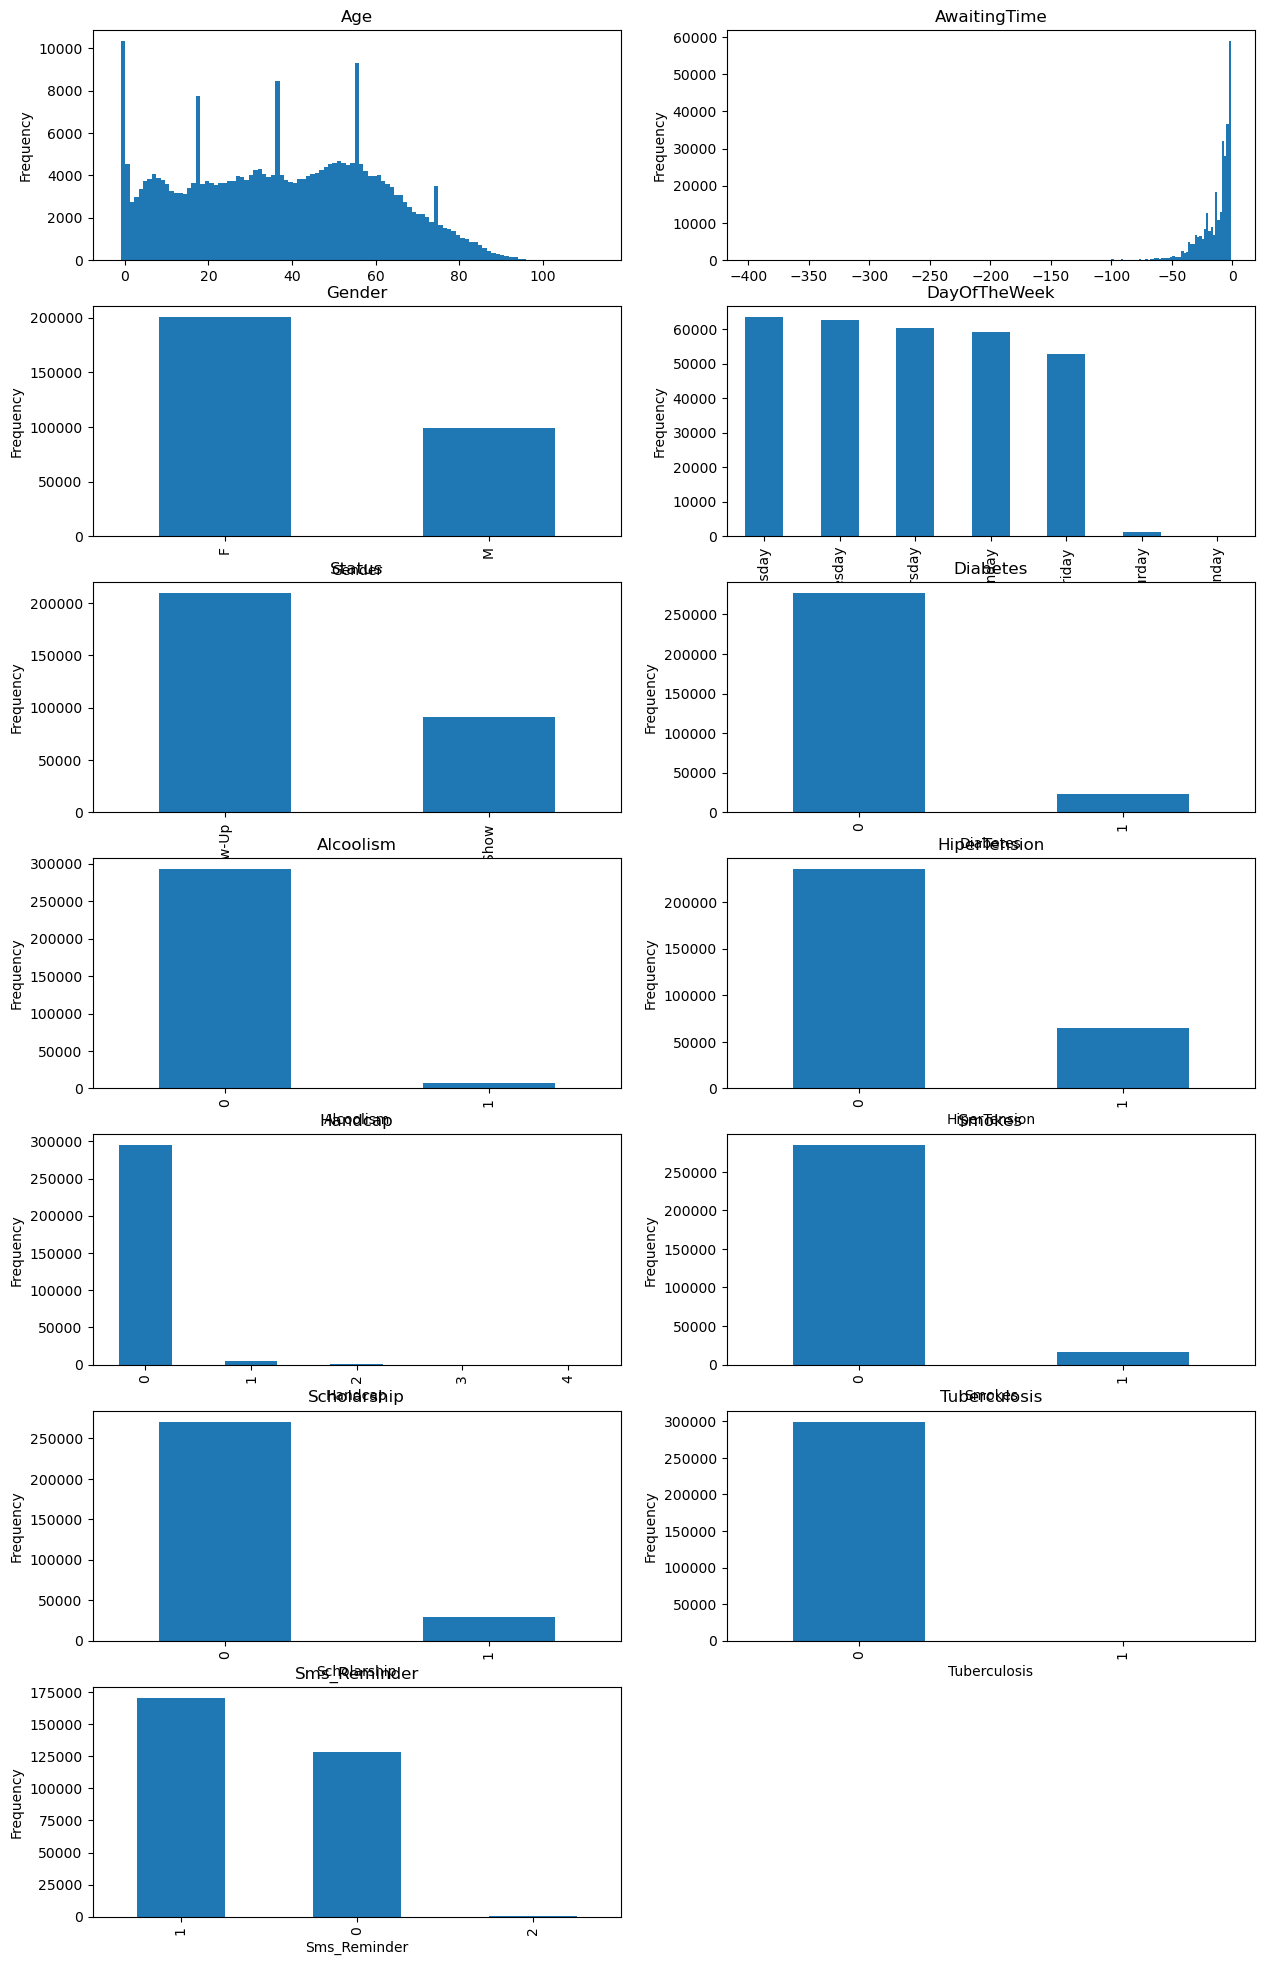

In [6]:
discrete_vars = ['Gender','DayOfTheWeek','Status','Diabetes', 
                 'Alcoolism', 'HiperTension','Handcap','Smokes', 
                 'Scholarship', 'Tuberculosis', 'Sms_Reminder']

features_plots(discrete_vars)



In [7]:
data[data['Age'] < 0]['Age'].value_counts().sum()

data = data[data['Age'] >= 0]

## This piece of code removes those values where the mentioned age of the patients are less than 0, signifying noise in the data

del data['Handcap']

## This piece of code removes the column 'Handcap' as it is not required in the analysis

data['AwaitingTime'] = data['AwaitingTime'].apply(lambda x: abs(x))



In [8]:
## Recoding the string Categorical Feature - "DayOfTheWeek" to Integers using the "dowmapping" dictionary

dow_mapping = {'Monday': 0, 'Tuesday':1, 'Wednesday': 2, 'Thursday': 3, 
               'Friday': 4, 'Saturday': 5, 'Sunday': 6}

data['DayOfTheWeek'] = data['DayOfTheWeek'].map(dow_mapping)



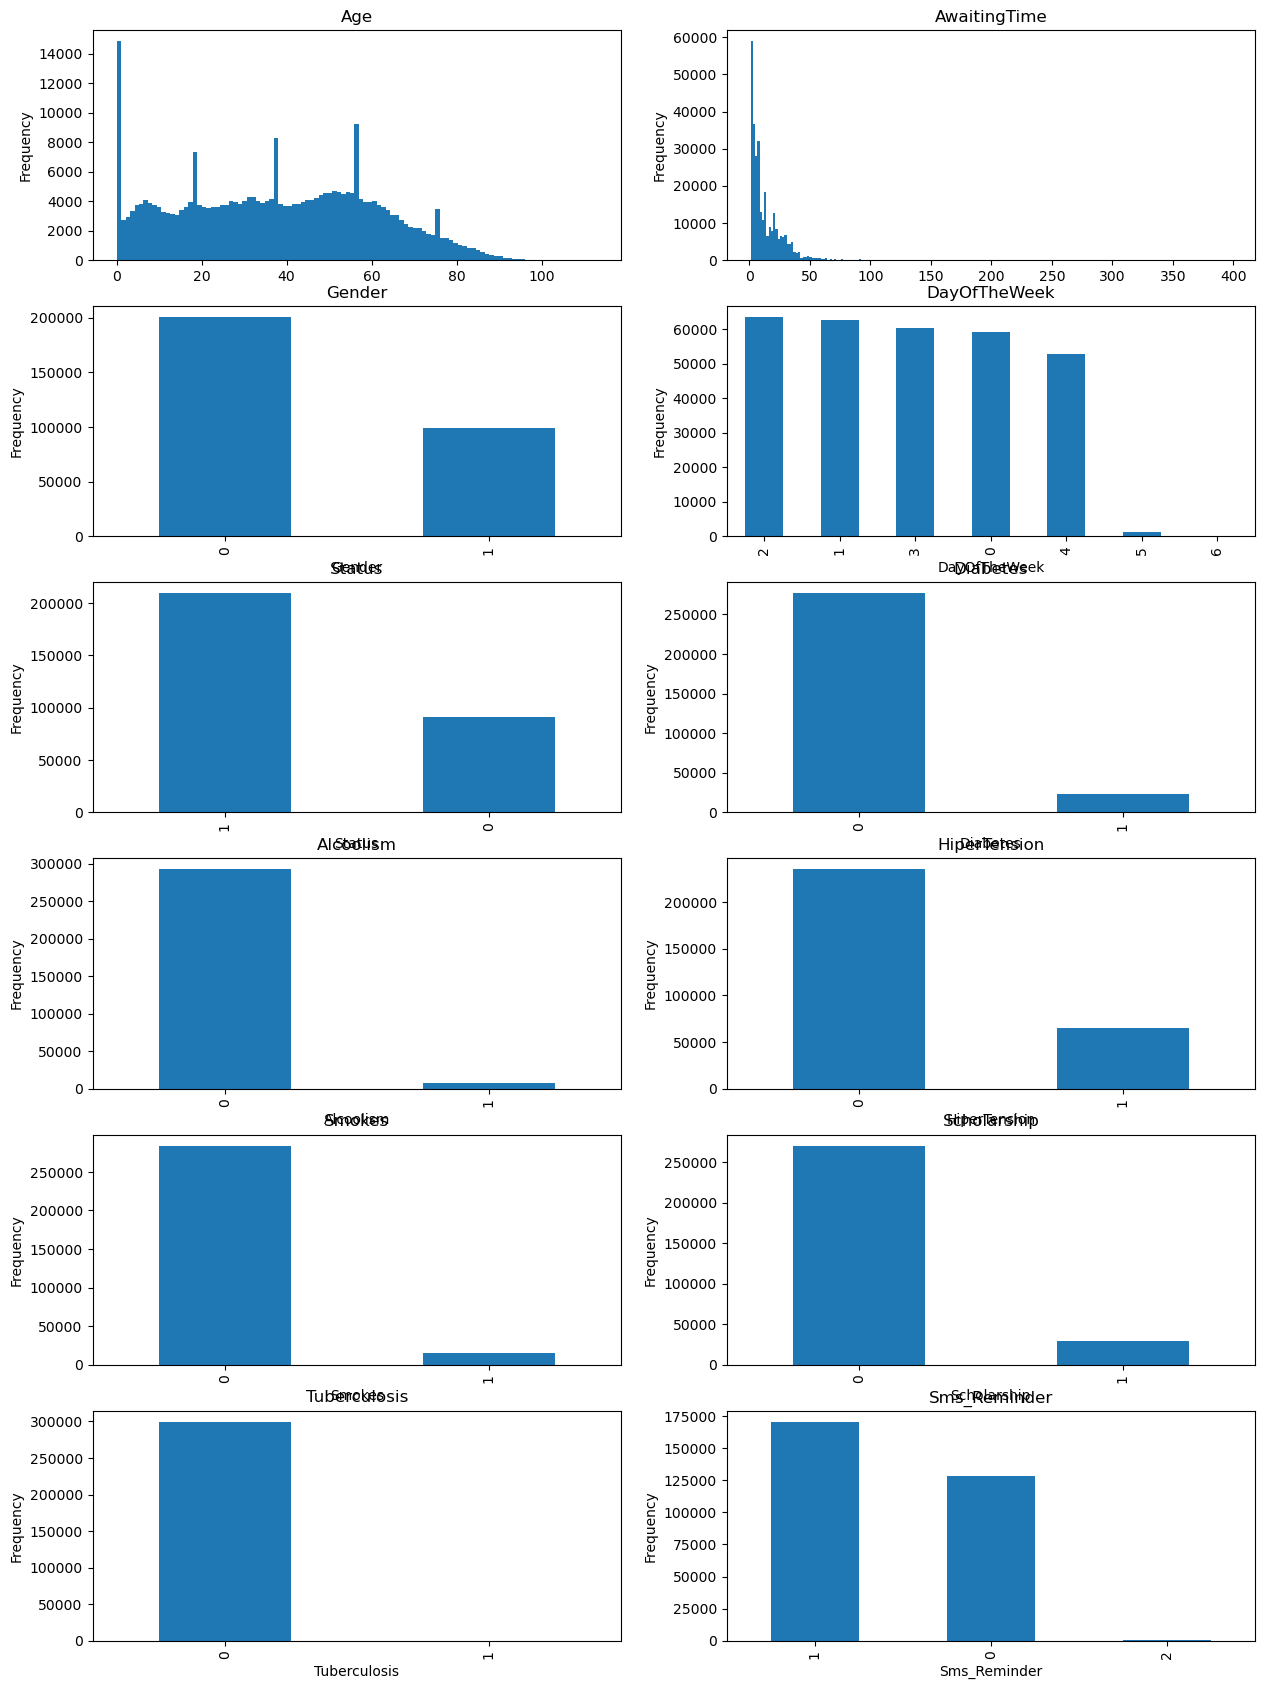

In [9]:
for field in ['Gender', 'Status']:
    data[field] = data[field].astype('category').cat.codes

discrete_vars = ['Gender', 'DayOfTheWeek', 'Status', 'Diabetes',
                    'Alcoolism', 'HiperTension', 'Smokes',
                         'Scholarship', 'Tuberculosis', 'Sms_Reminder']

features_plots(discrete_vars)

(0.0, 120.0)

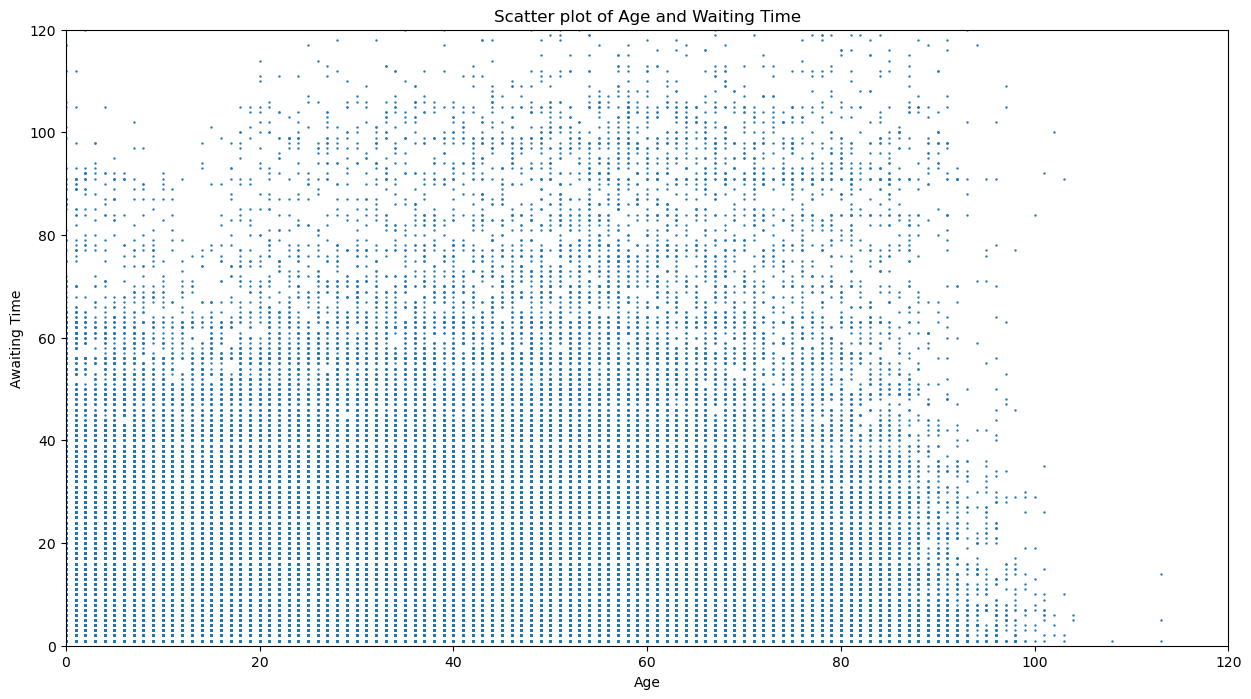

In [10]:
plt.scatter(data['Age'], data['AwaitingTime'], s =0.5)

plt.title('Scatter plot of Age and Waiting Time')

plt.xlabel('Age')

plt.ylabel('Awaiting Time')

plt.xlim(0, 120)

plt.ylim(0, 120)

## Plotting a Scatter plot between 'Age' and 'AwaitingTime'




In [11]:
pd.set_option('display.width', 100)

correlations = data[['Age', 'AwaitingTime']].corr(method = 'pearson')

print(correlations)

## Correlation between 'Age' and 'AwaitingTime'


                   Age  AwaitingTime
Age           1.000000     -0.004176
AwaitingTime -0.004176      1.000000


Text(0, 0.5, 'Frequency')

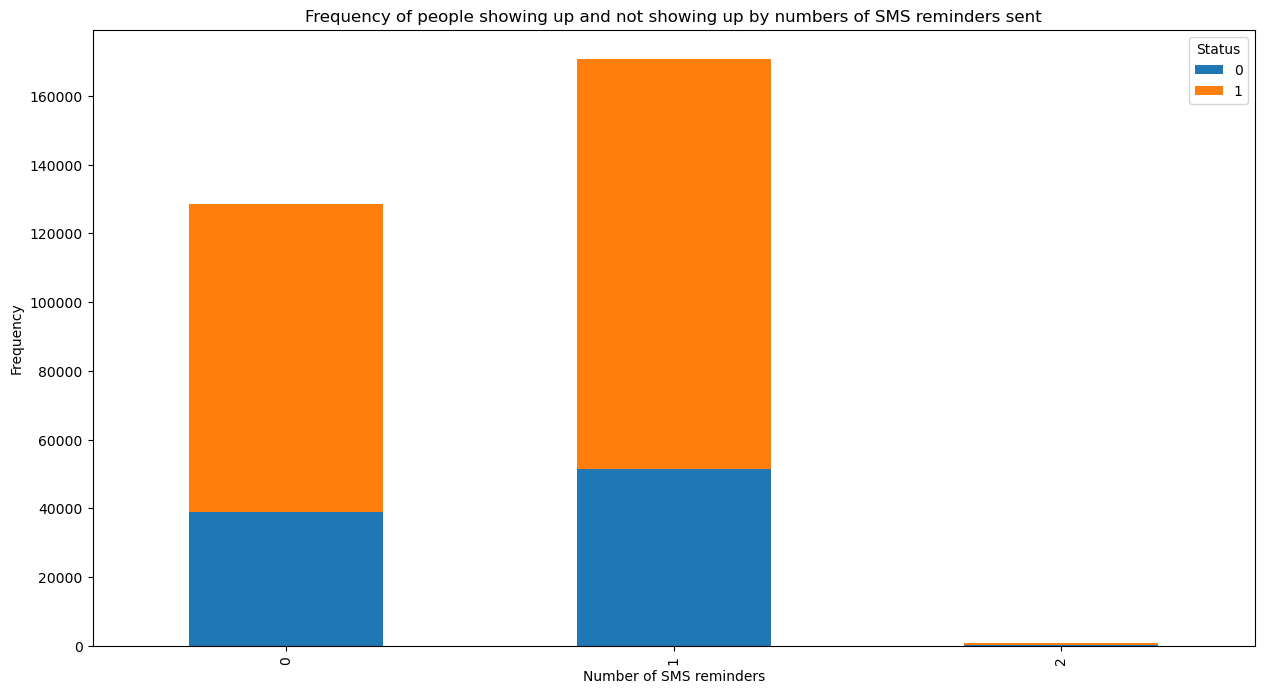

In [12]:
data_dow_status = data.groupby(['Sms_Reminder', 'Status'])['Sms_Reminder'].count().unstack('Status').fillna(0)

data_dow_status[[0,1]].plot(kind = 'bar', stacked= True)

plt.title('Frequency of people showing up and not showing up by numbers of SMS reminders sent')

plt.xlabel('Number of SMS reminders')

plt.ylabel('Frequency')


## Plotting a Bar plot between 'Sms_Reminder' and 'Status'


Text(0, 0.5, 'Frequency')

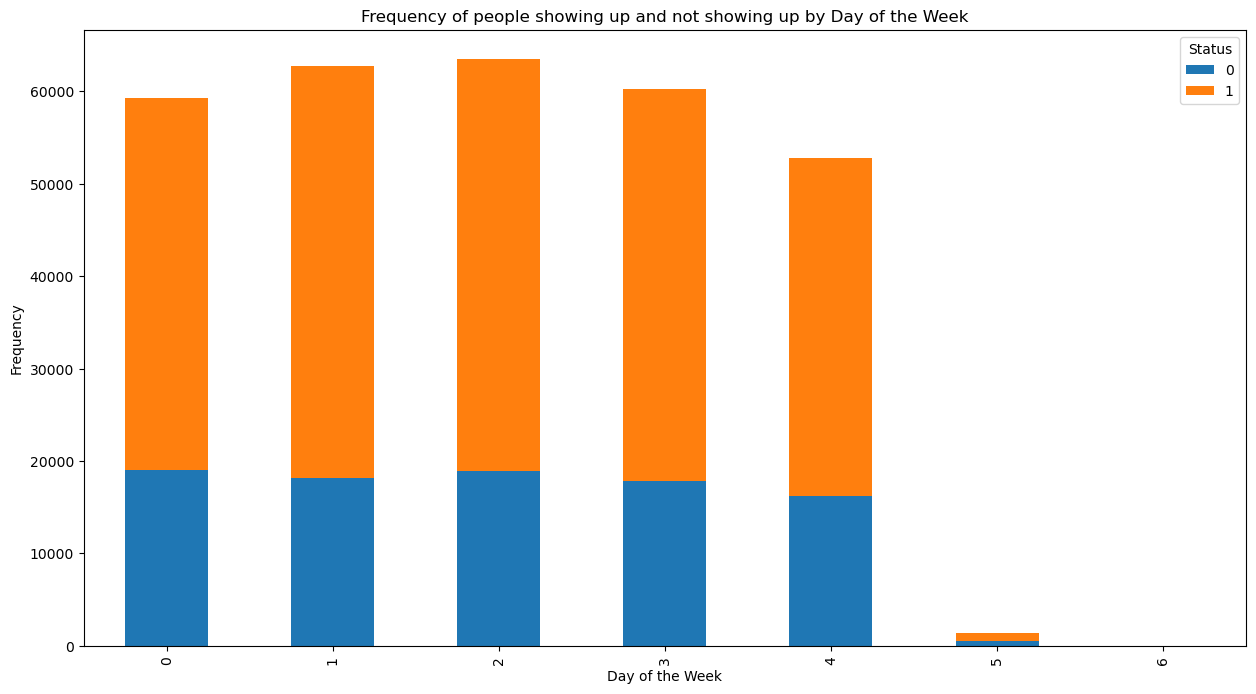

In [13]:
data_dow_status = data.groupby(['DayOfTheWeek', 'Status'])['DayOfTheWeek'].count().unstack('Status').fillna(0)

data_dow_status[[0, 1]].plot(kind = 'bar', stacked = True)

plt.title('Frequency of people showing up and not showing up by Day of the Week')

plt.xlabel('Day of the Week')

plt.ylabel('Frequency')

## Plotting a Stacked Bar plot between 'DayOfTheWeek' and 'Status'


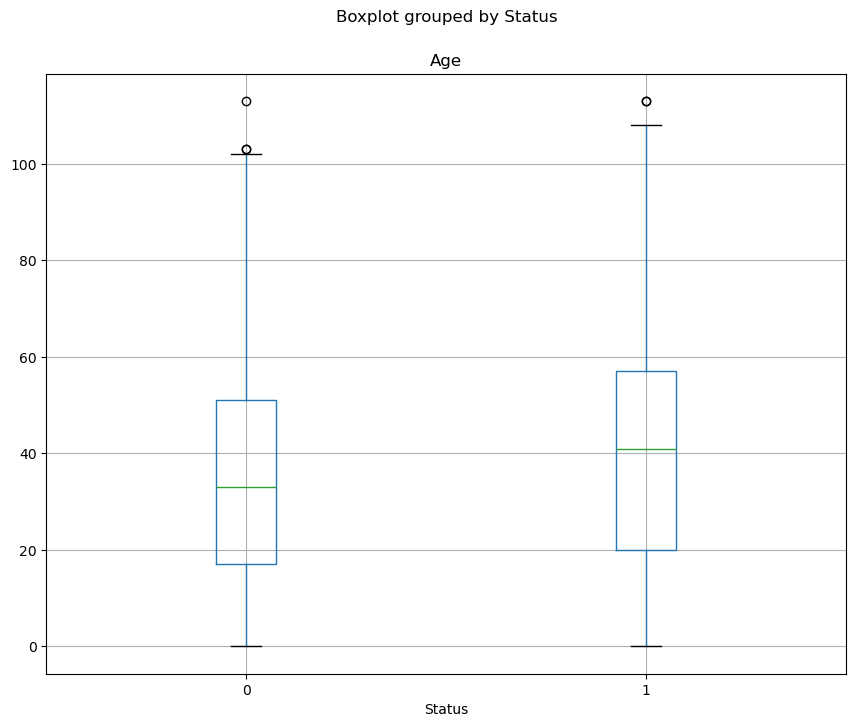

In [14]:
data.boxplot(by = 'Status', return_type= 'axes', column = ['Age'], figsize = (10, 8))

plt.show()

## Plotting a Box plot between 'Age' and 'Status'


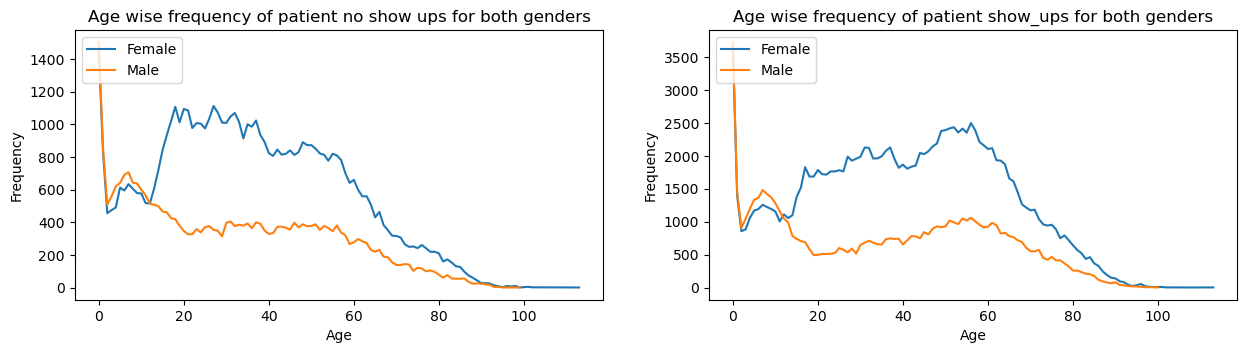

In [15]:
plt.figure(figsize= (15, 3.5))

for i, status in enumerate(['no show ups', 'show_ups']):
    
    data_show = data[data['Status'] == i]
    plt.subplot(1,2, i+1)

    for gender in [0, 1]:
        data_gender = data_show[data_show['Gender'] == gender]
        freq_age = data_gender['Age'].value_counts().sort_index()
        freq_age.plot()

    plt.title('Age wise frequency of patient %s for both genders' %status)
    plt.xlabel('Age')
    plt.ylabel('Frequency')

    plt.legend(['Female', 'Male'], loc = 'upper left')


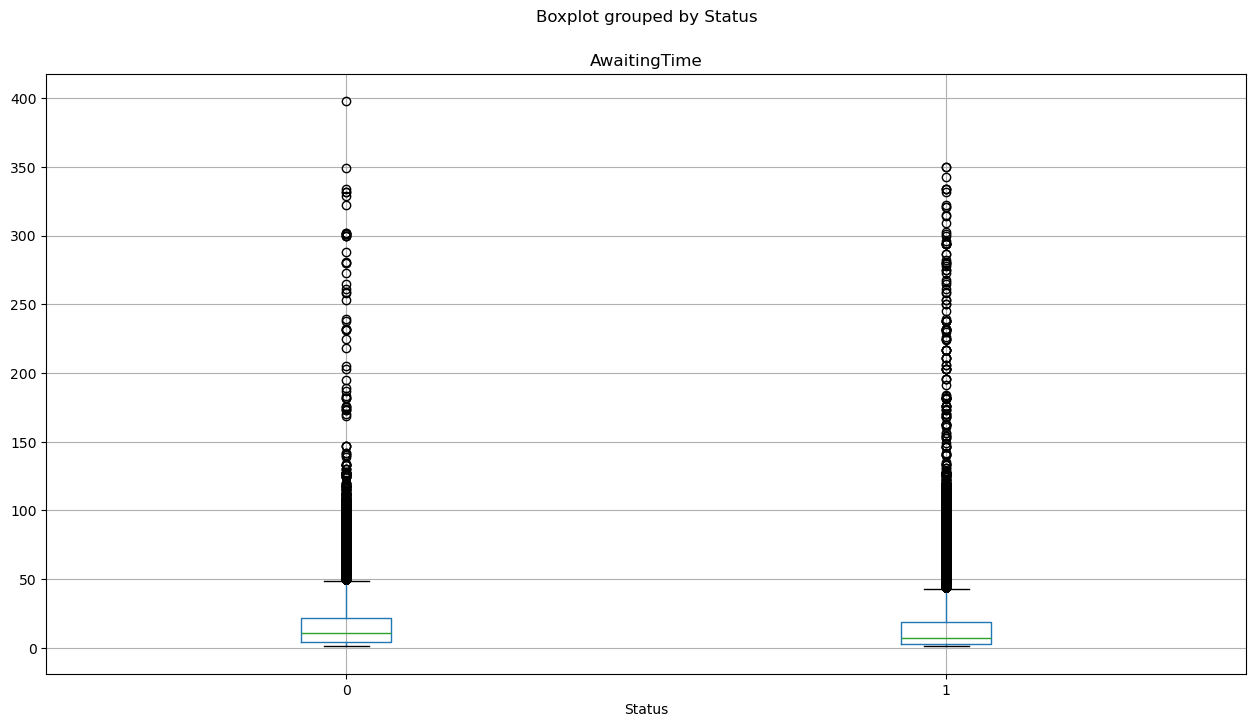

In [16]:
data.boxplot(column= ['AwaitingTime'], return_type= 'axes', by = 'Status')

plt.show()

## Plotting a Box plot of 'Awaiting Time' by 'Status' 

In [17]:
for col in ['AppointmentRegistration', 'ApointmentData']:
    for index, component in enumerate(['year', 'month','day']):
        data['%s_%s' %(col, component)] = data[col].apply(lambda x: int(x.split('T')[0].split('-')[index]))

## Breaking AppointmentRegistration and AppointmentData features into their respective year, month, and day components.



In [18]:
for index, component in enumerate(['hour', 'min', 'sec']):
    data['%s_%s' %('AppointmentRegistration', component)] = data['AppointmentRegistration'].apply(lambda x: int(x.split('T')[1][:-1].split(':')[index]))

## Splitting the time component of AppointmentRegistration into hour, minute, and second components.

In [19]:
data.head()

,Age,Gender,AppointmentRegistration,ApointmentData,DayOfTheWeek,Status,Diabetes,Alcoolism,HiperTension,Smokes,...,AwaitingTime,AppointmentRegistration_year,AppointmentRegistration_month,AppointmentRegistration_day,ApointmentData_year,ApointmentData_month,ApointmentData_day,AppointmentRegistration_hour,AppointmentRegistration_min,AppointmentRegistration_sec
0,19,1,2014-12-16T14:46:25Z,2015-01-14T00:00:00Z,2,1,0,0,0,0,...,29,2014,12,16,2015,1,14,14,46,25
1,24,0,2015-08-18T07:01:26Z,2015-08-19T00:00:00Z,2,1,0,0,0,0,...,1,2015,8,18,2015,8,19,7,1,26
2,4,0,2014-02-17T12:53:46Z,2014-02-18T00:00:00Z,1,1,0,0,0,0,...,1,2014,2,17,2014,2,18,12,53,46
3,5,1,2014-07-23T17:02:11Z,2014-08-07T00:00:00Z,3,1,0,0,0,0,...,15,2014,7,23,2014,8,7,17,2,11
4,38,1,2015-10-21T15:20:09Z,2015-10-27T00:00:00Z,1,1,0,0,0,0,...,6,2015,10,21,2015,10,27,15,20,9


Model Name: Decision Tree Classifier
Test Accuracy (Accuracy Score): 0.589329
Test Accuracy (ROC AUC Score): 0.522940
Training Accuracy (Accuracy Score): 0.999952
Area Under the Precision- Recall Curve: 0.112569


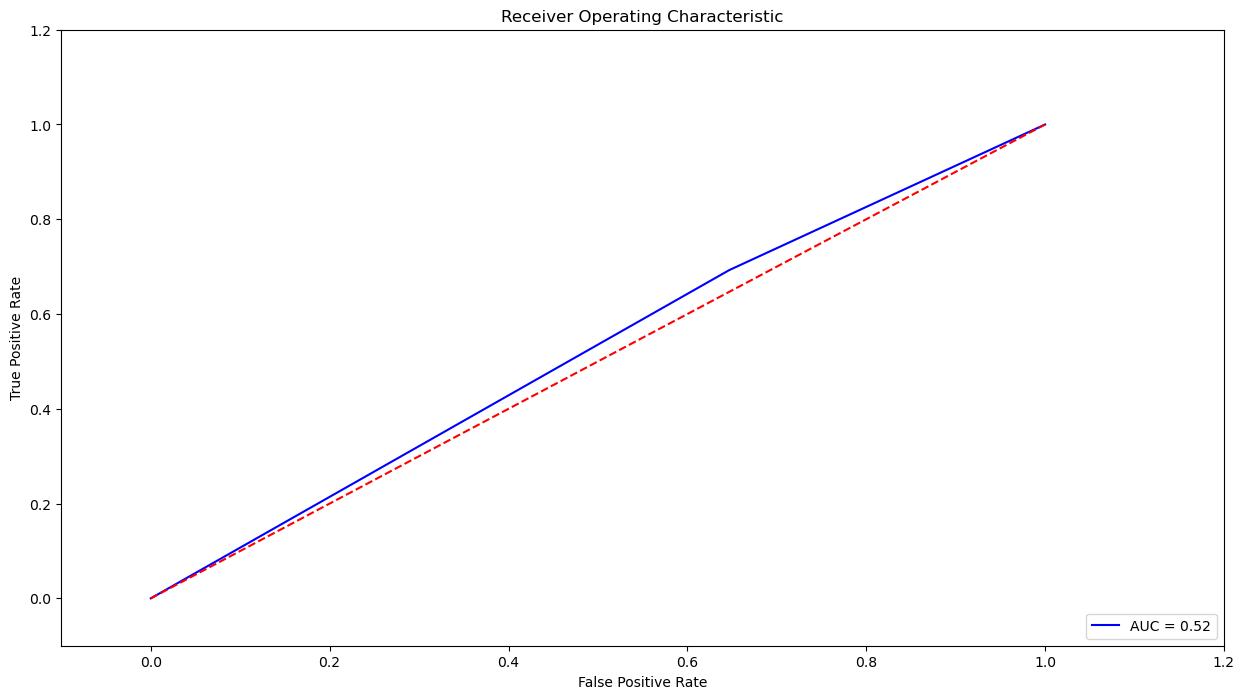

In [20]:
## Function Definiton to compute ML model's accuracy by applying reliable methods

def model_performance(model_name, X_train, y_train, y_test, Y_pred):
    
    print("Model Name: %s" %model_name) ## Printing the respective ML model name
     
    ## Model's accuracy score
     
    print('Test Accuracy (Accuracy Score): %f' %metrics.accuracy_score(y_test, Y_pred))
    
    ## ROC Score

    print('Test Accuracy (ROC AUC Score): %f' %metrics.roc_auc_score(y_test, Y_pred))

    print('Training Accuracy (Accuracy Score): %f' %clf.score(X_train, y_train))

    fpr, tpr, thresholds = metrics.precision_recall_curve(y_test, Y_pred)
    
    print('Area Under the Precision- Recall Curve: %f' %metrics.auc(fpr, tpr))

    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, Y_pred)
   
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)

    plt.title('Receiver Operating Characteristic')

    plt.plot(false_positive_rate, true_positive_rate, 'b', label = 'AUC = %0.2f' % roc_auc)

    plt.legend(loc = 'lower right')

    plt.plot([0,1], [0,1], 'r--')

    plt.xlim([-0.1, 1.2])

    plt.ylim([-0.1, 1.2])

    plt.ylabel('True Positive Rate')

    plt.xlabel('False Positive Rate')

    plt.show()

## The given set of features were selected for the model training process

features_of_choice = [u'Age', u'Gender', 'DayOfTheWeek', 'Diabetes','Alcoolism', 'HiperTension',
                         'Smokes', 'Scholarship', 'Tuberculosis', 'Sms_Reminder', 'AwaitingTime', 'AppointmentRegistration_year',
                              'AppointmentRegistration_month',
                                   'AppointmentRegistration_day', 'ApointmentData_year', 'ApointmentData_month',
                                        'ApointmentData_day', 'AppointmentRegistration_hour', 
                                             'AppointmentRegistration_min', 'AppointmentRegistration_sec']


x = np.array(data[features_of_choice])

y= np.array(data['Status'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state= 1)

## clf is the Model Object containing the Decision Tree Classifier model

clf = DecisionTreeClassifier()

clf.fit(x_train, y_train)

## Currently the other model parameters are set to default

y_pred = clf.predict(x_test)

model_performance('Decision Tree Classifier', x_train, y_train, y_test, y_pred)



Model Name: Kernel Approximation
Test Accuracy (Accuracy Score): 0.695619
Test Accuracy (ROC AUC Score): 0.500000
Training Accuracy (Accuracy Score): 0.698398
Area Under the Precision- Recall Curve: 0.152191


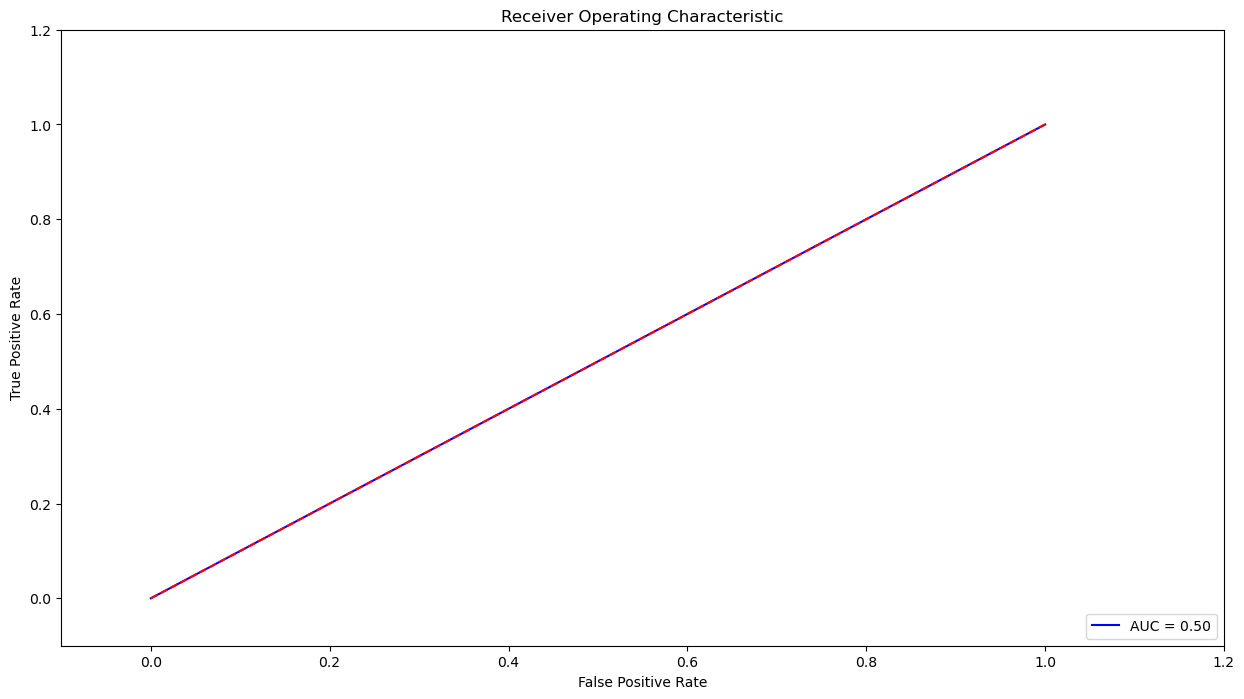

In [21]:
## Trying a SGD Classifier model with applying Kernel Approximation

rbf_feature = kernel_approximation.RBFSampler(gamma= 1, random_state= 1)

X_train = rbf_feature.fit_transform(x_train)

clf = SGDClassifier()

clf.fit(X_train, y_train)

X_test = rbf_feature.fit_transform(x_test)

Y_pred = clf.predict(X_test)

model_performance('Kernel Approximation', X_train, y_train, y_test, Y_pred)



Model Name: Random Forest Classifier
Test Accuracy (Accuracy Score): 0.633629
Test Accuracy (ROC AUC Score): 0.536377
Training Accuracy (Accuracy Score): 0.989519
Area Under the Precision- Recall Curve: 0.129560


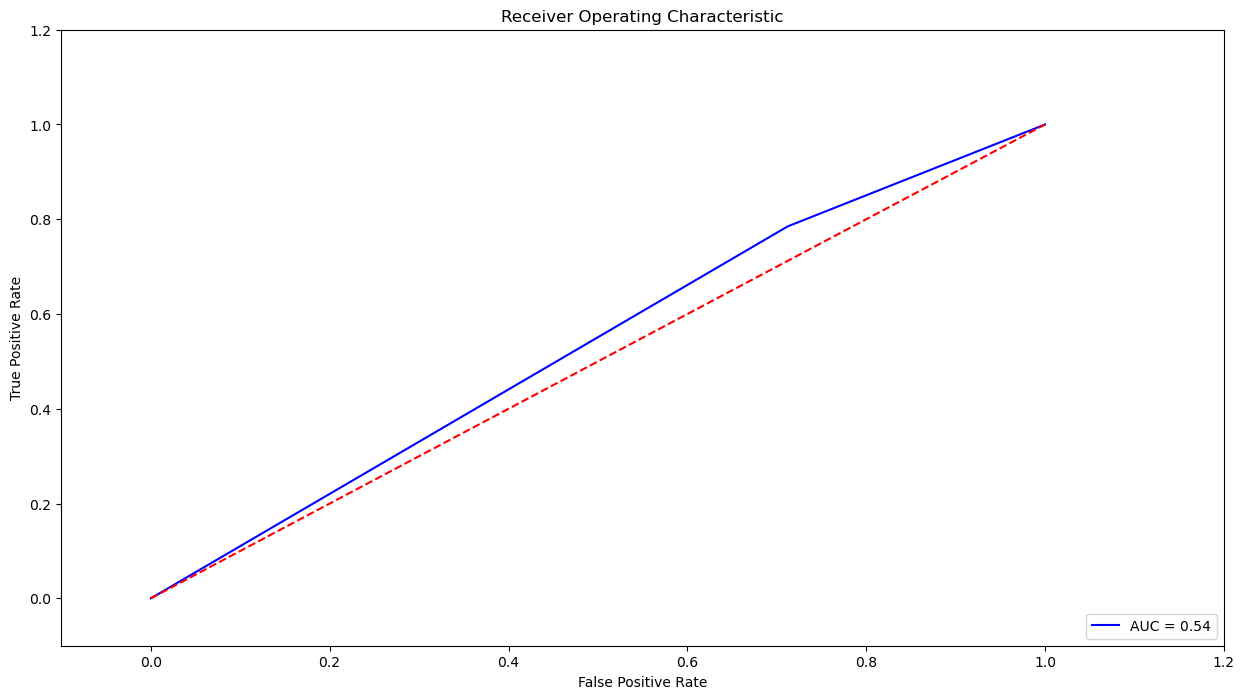

In [22]:
## Training a Random Forest Classifier Model, as the Model Accuracy Features aren't still up to standards

clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                                   max_depth=None, max_features= None, max_leaf_nodes=None, min_samples_leaf=1,
                                        min_samples_split = 2, min_weight_fraction_leaf= 0.0, n_estimators= 10, n_jobs= 1, oob_score= False, random_state= None, verbose= 0, warm_start= False)

clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

model_performance('Random Forest Classifier', x_train, y_train, y_test, y_pred)

Model Name: Gradient Boosting
Test Accuracy (Accuracy Score): 1.000000
Test Accuracy (ROC AUC Score): 1.000000
Training Accuracy (Accuracy Score): 0.707988
Area Under the Precision- Recall Curve: 0.304381


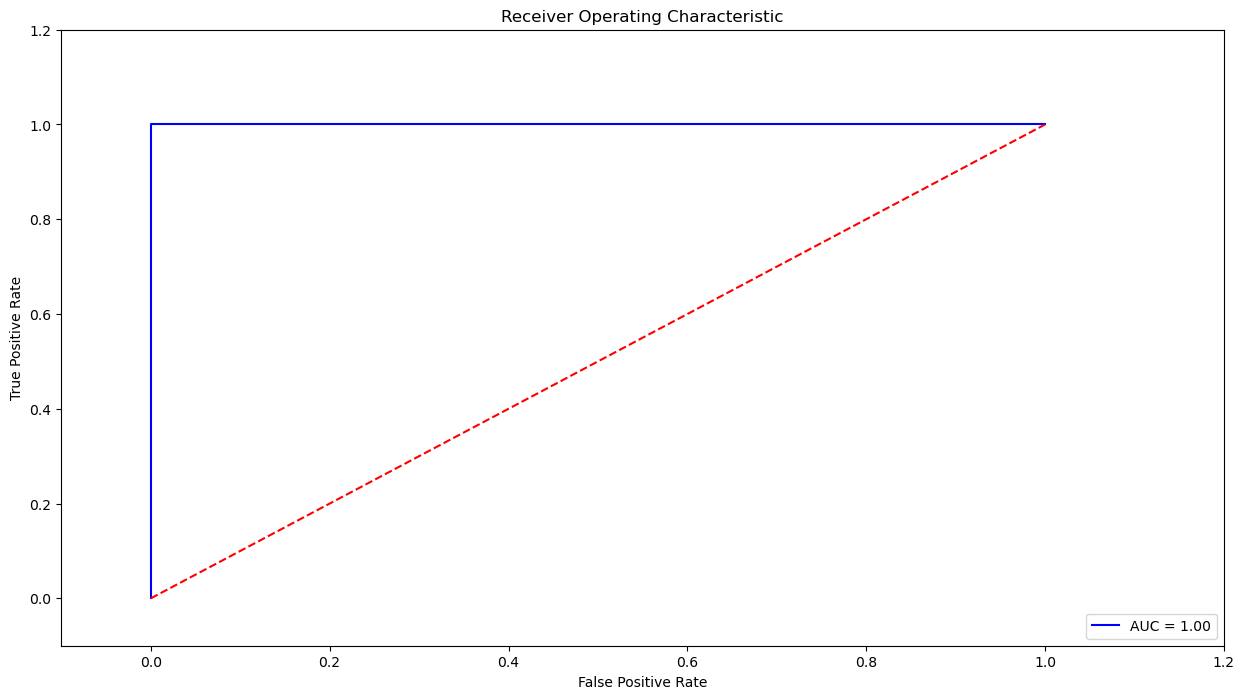

Confusion Matrix: 
 [[ 1192 26202]
 [  707 61898]]


In [23]:
## Training a Gradient Boosting Classifier Model, with modified hyperparameters

clf = GradientBoostingClassifier(n_estimators= 200, max_depth = 5, learning_rate= 0.1, max_features= 10)

clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

model_performance('Gradient Boosting', x_train, y_train, y_test, y_test)

cm = confusion_matrix(y_test, y_pred)

print('Confusion Matrix: \n', cm)


In [24]:
## The Features-specific weights assigned by the Gradient Boosting Classifier

for feature, score in zip(features_of_choice, list(clf.feature_importances_)):
    print(' %s \t %f' %(feature, score))

    

 Age 	 0.283085
 Gender 	 0.005661
 DayOfTheWeek 	 0.036725
 Diabetes 	 0.002491
 Alcoolism 	 0.014971
 HiperTension 	 0.009344
 Smokes 	 0.020277
 Scholarship 	 0.013482
 Tuberculosis 	 0.001263
 Sms_Reminder 	 0.041346
 AwaitingTime 	 0.197346
 AppointmentRegistration_year 	 0.014794
 AppointmentRegistration_month 	 0.031808
 AppointmentRegistration_day 	 0.032430
 ApointmentData_year 	 0.024112
 ApointmentData_month 	 0.051564
 ApointmentData_day 	 0.077483
 AppointmentRegistration_hour 	 0.061233
 AppointmentRegistration_min 	 0.042149
 AppointmentRegistration_sec 	 0.038434
